# T008 · Protein data acquisition: Protein Data Bank (PDB) 

Authors:

- Anja Georgi, CADD seminar, 2017, Charité/FU Berlin
- Majid Vafadar, CADD seminar, 2018, Charité/FU Berlin
- Jaime Rodríguez-Guerra, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, [Volkamer lab, Charité](https://volkamerlab.org/)

__Talktorial T008__: This talktorial is part of the TeachOpenCADD pipeline described in the first TeachOpenCADD publication ([_J. Cheminform._ (2019), **11**, 1-7](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x)), comprising of talktorials T001-T010.

## Aim of this talktorial

In this talktorial, we conduct the groundwork for the next talktorial where we will generate a ligand-based ensemble pharmacophore for EGFR. Therefore, we 
(i) fetch all PDB IDs for EGFR from the PDB database that fullfil certain criteria (e.g. ligand-bound structures with high resolution), 
(ii) retrieve protein-ligand structures with the best structural quality, 
(iii) align all structures, and 
(iv) extract and save the ligands to be used in the next talktorial.

### Contents in Theory

* Protein Data Bank (PDB)
* Query the PDB using the Python packages `biotite` and `pypdb`

### Contents in Practical

* Select a query protein
* Get the number of PDB entries for a query protein
* Find PDB entries fullfilling certain conditions
* Select PDB entries with the highest resolution
* Get metadata of ligands from top structures
* Draw top ligand molecules
* Create protein-ligand ID pairs
* Align PDB structures and extract ligands

### References

* Protein Data Bank 
([PDB website](http://www.rcsb.org/))
* `pypdb` Python package 
([_Bioinformatics_ (2016), **1**, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543); [documentation](http://www.wgilpin.com/pypdb_docs/html/))
* `biotite` Python package ([_BMC Bioinformatics_ (2018), **19**](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2367-z); [documentation](https://www.biotite-python.org/))
* Molecular superposition with the Python package `opencadd` ([repository](https://github.com/volkamerlab/opencadd))

## Theory

### Protein Data Bank (PDB)

The RCSB Protein Data Bank (PDB) is a comprehensive structural biology information database and a key resource in areas of structural biology, such as structural genomics and drug design ([PDB website](http://www.rcsb.org/)).

Structural data is generated from structural determination methods such as X-ray crystallography (most common method), nuclear magnetic resonance (NMR), and cryo electron microscopy (cryo-EM). 
For each entry, the database contains (i) the 3D coordinates of the atoms and the bonds connecting these atoms for proteins, ligand, cofactors, water molecules, and ions, as well as (ii) meta information on the structural data such as the PDB ID, the authors, the deposition date, the structural determination method used, and the structural resolution.
The structural resolution is a measure of the collected data quality and has the unit Å (Angstrom); the lower the value, the higher the quality of the structure. 

The PDB website offers a 3D visualization of the protein structures (with ligand interactions if available) and a structure quality metrics, as can be seen for the PDB entry of an example epidermal growth factor receptor (EGFR) with the PDB ID [3UG5](https://www.rcsb.org/structure/3UG5).

![protein ligand complex](images/protein-ligand-complex.png)

*Figure 1*: The protein structure (in gray) with an interacting ligand (in green) is shown for an example epidermal growth factor receptor (EGFR) with the PDB ID 3UG5.

### Query the PDB using the Python packages `biotite` and `pypdb`

Each structure in the PDB database is linked to many different fields to hold meta information. Check out the complete list of available fields for [chemicals](https://search.rcsb.org/chemical-search-attributes.html)/[structures](https://search.rcsb.org/structure-search-attributes.html) and supported operators on the RCSB website. The Python package `biotite` provides the convenient module `databases.rcsb` (see [docs](https://www.biotite-python.org/apidoc/biotite.database.rcsb.html)), which allows us to query one (`FieldQuery`, see [docs](https://www.biotite-python.org/apidoc/biotite.database.rcsb.FieldQuery.html#biotite.database.rcsb.FieldQuery)) or more (`CompositeQuery`, see [docs](https://www.biotite-python.org/apidoc/biotite.database.rcsb.CompositeQuery.html#biotite.database.rcsb.CompositeQuery)) of these fields to retrieve a count (`count`) or list (`search`) of PDB IDs that match our criteria. 

The Python package `pypdb` offers an interface for the PDB to not only query for PDB IDs but also to download associated metadata and structural files ([_Bioinformatics_ (2016), **1**, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543), [documentation](http://www.wgilpin.com/pypdb_docs/html/)). Check out the [demo](https://github.com/williamgilpin/pypdb/blob/master/demos/demos.ipynb) notebook introducing the `pypdb` API.

We will use both packages in this notebook: `biotite` to quickly filter down the many structures in the PDB given certain criteria and `pypdb` to download metadata and structural files for specific PDB entries of interest.

## Practical

In [1]:
# In this notebook, we need biotite>=0.30.0!
# Installing the latest biotite version via conda works only with python>=3.7
# In case, you are running on a python<3.7, 
# you will need to install the latest biotite version from GitHub 
from platform import python_version
if python_version() < "3.7":
    !pip install https://github.com/biotite-dev/biotite/archive/master.tar.gz

In [2]:
import collections
import logging
import pathlib
import time
import warnings
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from tqdm.auto import tqdm
import redo
import requests_cache
import nglview
import pypdb
import biotite.database.rcsb as rcsb
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure

# Disable some unneeded warnings
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# Cache requests -- this will speed up repeated queries to PDB
requests_cache.install_cache("rcsb_pdb", backend="memory")

In [3]:
# Define paths
HERE = pathlib.Path(_dh[-1])
DATA = HERE / "data"

### Select a query protein

We use EGFR as query protein for this talktorial. The UniProt ID of EGFR is `P00533`, which will be used in the following to query the PDB database.

In [4]:
uniprot_id = "P00533"

### Get the number of PDB entries for a query protein 

How many structures are available in the PDB for EGFR (at the time this notebook was last run)?

In [5]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
today = datetime.datetime.now()
print(
    f"Number of structures on {today.year}-{today.month}-{today.day}: {rcsb.count(query_by_uniprot_id)}"
)

Number of structures on 2021-9-2: 227


How many structures were available in every year since the [PDB was established in 1971](https://www.rcsb.org/pages/about-us/history)?

In [6]:
# Define lists for years and number of structures available in a given year
years = range(1971, datetime.datetime.now().year)
n_structures = []

for year in years:
    # Set latest date for allowed deposition
    before_deposition_date = f"{year}-12-31T23:59:59Z"
    # Set up query for structures deposited latest at given date
    query_by_deposition_date = rcsb.FieldQuery(
        "rcsb_accession_info.deposit_date", less_or_equal=before_deposition_date
    )
    # Set up combined query
    query = rcsb.CompositeQuery(
        [query_by_uniprot_id, query_by_deposition_date],
        "and",
    )
    # Count matching structures and add to list
    n_structures.append(rcsb.count(query))

Plot the results!

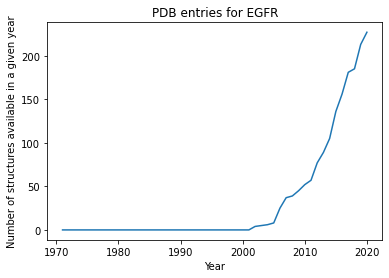

In [7]:
plt.plot(years, n_structures)
plt.title("PDB entries for EGFR")
plt.xlabel("Year")
plt.ylabel("Number of structures available in a given year");

### Find PDB entries fullfilling certain conditions

We will search for PDB IDs describing structures in the PDB that fulfill the following criteria:

- **Structures for UniProt ID P00533**: This is our target of interest, EGFR!
- **Structures deposited before 2020**: This step is for TeachOpenCADD-internal maintanence purposes. We will only consider structures that were deposited before 2020. That way the results of this notebook will stay the same over time, allowing us to check with our continuous integration (CI) that this notebook does not go out of service.
- **Structure resolved by X-ray crystallography**: We could include all methods but let's check out the API on how we can select experimental methods.
- **Structure has a resolution less than or equal to 3.0**: The lower the resolution value, the higher is the quality of the structure, i.e. the certainty that the assigned 3D coordinates of the atoms are correct. Atomic orientations can be determined below 3 Å. Thus, this threshold is often used for structures relevant for structure-based drug design.
- **Structure has only one chain**: We do this to make our lives easier lateron.
- **Structure has a ligand with molecular weight greater than 100.0 Da**: PDB-annotated ligands can be ligands, but also solvents and ions. In order to filter only ligand-bound structures, we keep only structures with annotated ligand of a at least 100.0 Da (many solvents and ions weight less). Note: this is a simple, but not comprehensive exclusion of solvents and ions. 

We make use of the `biotite` package again to query for PDB IDs based on the following combined queries:

| Field | Operator | Value |
|-|-|-|
| `rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession` | `exact_match` | P00533 |
| `rcsb_accession_info.deposit_date` | `less` | 2020-01-01 |
| `exptl.method` | `exact_match` | X-RAY DIFFRACTION |
| `rcsb_entry_info.resolution_combined` | `less_or_equal` | $3.0$ |
| `rcsb_entry_info.deposited_polymer_entity_instance_count` | `equals` | $1$ |
| `chem_comp.formula_weight` | `greater` | $100.0$ |

We define our criteria.

In [8]:
uniprot_id = "P00533"
before_deposition_date = "2020-01-01T00:00:00Z"
experimental_method = "X-RAY DIFFRACTION"
max_resolution = 3.0
n_chains = 1
min_ligand_molecular_weight = 100.0

We set up each query.

In [9]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
query_by_deposition_date = rcsb.FieldQuery(
    "rcsb_accession_info.deposit_date", less=before_deposition_date
)
query_by_experimental_method = rcsb.FieldQuery("exptl.method", exact_match=experimental_method)
query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined", less_or_equal=max_resolution
)
query_by_polymer_count = rcsb.FieldQuery(
    "rcsb_entry_info.deposited_polymer_entity_instance_count", equals=n_chains
)
query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight", molecular_definition=True, greater=min_ligand_molecular_weight
)

We perform each of the queries alone and check the number of matches per condition.

In [10]:
print(f"Number of structures with UniProt ID {uniprot_id}: {rcsb.count(query_by_uniprot_id)}")
print(
    f"Number of structures deposited before {before_deposition_date}: {rcsb.count(query_by_deposition_date)}"
)
print(
    f"Number of structures resolved by {experimental_method}: {rcsb.count(query_by_experimental_method)}"
)
print(
    f"Number of structures with resolution less than or equal to {max_resolution}: {rcsb.count(query_by_resolution)}"
)
print(f"Number of structures with only {n_chains} chain: {rcsb.count(query_by_polymer_count)}")
print(
    f"Number of structures with ligand of more than or equal to {min_ligand_molecular_weight} Da: {rcsb.count(query_by_ligand_mw)}"
)

Number of structures with UniProt ID P00533: 227
Number of structures deposited before 2020-01-01T00:00:00Z: 166368
Number of structures resolved by X-RAY DIFFRACTION: 159578
Number of structures with resolution less than or equal to 3.0: 150822
Number of structures with only 1 chain: 68467
Number of structures with ligand of more than or equal to 100.0 Da: 181779


We combine all queries with the `and` operator to match only PDB IDs that fulfill all the conditions.

In [11]:
query = rcsb.CompositeQuery(
    [
        query_by_uniprot_id,
        query_by_deposition_date,
        query_by_experimental_method,
        query_by_resolution,
        query_by_polymer_count,
        query_by_ligand_mw,
    ],
    "and",
)
pdb_ids = rcsb.search(query)
print(f"Number of matches: {len(pdb_ids)}")
print("Selected PDB IDs:")
print(*pdb_ids)

Number of matches: 110
Selected PDB IDs:
6S9C 6S9D 5HG9 5HG7 5HG8 5HG5 6JXT 2EB2 2EB3 3UG2 3UG1 5GMP 5U8L 4HJO 6S8A 4LI5 6JX4 6JX0 6JWL 5GTZ 5J9Y 5J9Z 4LQM 4G5J 5XDL 5XDK 4I23 4I22 5UG8 5UG9 4I1Z 6S89 5UGB 5UGC 5UGA 5HCX 5CAV 5CAU 1M17 5HCY 5HCZ 2RGP 5X26 4RJ4 5X27 5C8M 5C8N 5C8K 4RJ8 4RJ7 4RJ6 5X28 4WKQ 5ZWJ 3BEL 3GOP 1M14 5CAS 5CAP 5CAQ 2GS2 5CAN 6D8E 5CAO 4ZAU 5CAL 4JRV 3POZ 4JR3 5EM5 5EDQ 5EDR 5EM8 5EDP 5EM6 5EM7 3VJO 2J5F 3VJN 5FED 5HIC 6JRK 5HIB 6JRJ 2ITV 4WRG 2ITW 2ITX 2ITZ 5FEE 2ITN 2ITP 4JQ8 2ITQ 4JQ7 2ITT 2ITU 6JRX 3W2S 3W33 3W2R 3W32 3W2Q 3W2P 3W2O 5GNK 5XGM 1XKK 6JZ0 5ZTO


### Select PDB entries with the hightest resolution

So far we have used certain search criteria to find PDB entries of interest. 

At the moment, we cannot access the structures' resolution directly via `biotite`; with `biotite` we can only check if the resolution fullfils a certain condition. Instead we download the full metadata for our selected PDB IDs. To this end, we use from the `pypdb` package the method `describe_pdb`. Each structure's metadata is returned as a dictionary.

Note: we only fetch meta information on PDB structures here, we do not fetch the structures (3D coordinates), yet.

> The `redo.retriable` line is a _decorator_. This wraps the function and provides extra functionality. In this case, it will retry failed queries automatically (10 times maximum).

In [12]:
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

In [13]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm(pdb_ids)]

  0%|          | 0/110 [00:00<?, ?it/s]

Let's take a look at the metadata of the first PDB IDs (keys only because the dictionary contains a lot of information, which we do not want to print here). Find more more information about the PDB metadata in the [Beginner's Guide to PDB Structures and the PDBx/mmCIF Format](https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/beginner%E2%80%99s-guide-to-pdb-structures-and-the-pdbx-mmcif-format).

In [14]:
print("\n".join(pdbs_data[0].keys()))

audit_author
cell
citation
diffrn
diffrn_detector
diffrn_radiation
diffrn_source
entry
exptl
exptl_crystal
exptl_crystal_grow
pdbx_audit_revision_category
pdbx_audit_revision_details
pdbx_audit_revision_group
pdbx_audit_revision_history
pdbx_audit_revision_item
pdbx_database_related
pdbx_database_status
pdbx_vrpt_summary
rcsb_accession_info
rcsb_entry_container_identifiers
rcsb_entry_info
rcsb_primary_citation
refine
refine_hist
refine_ls_restr
reflns
reflns_shell
software
struct
struct_keywords
symmetry
rcsb_id


Let's take a closer look at two keys that will be of interest to us: The `"entry"` key which contains the PDB ID (`"id"`) and the `"rcsb_entry_info"` key which contains amongst others the structure's resolution (`"resolution_combined"`).

In [15]:
pdbs_data[0]["entry"]

{'id': '6S9C'}

In [16]:
pdbs_data[0]["rcsb_entry_info"]

{'assembly_count': 1,
 'branched_entity_count': 0,
 'cis_peptide_count': 0,
 'deposited_atom_count': 2486,
 'deposited_hydrogen_atom_count': 0,
 'deposited_model_count': 1,
 'deposited_modeled_polymer_monomer_count': 301,
 'deposited_nonpolymer_entity_instance_count': 2,
 'deposited_polymer_entity_instance_count': 1,
 'deposited_polymer_monomer_count': 329,
 'deposited_solvent_atom_count': 20,
 'deposited_unmodeled_polymer_monomer_count': 28,
 'diffrn_radiation_wavelength_maximum': 1.0,
 'diffrn_radiation_wavelength_minimum': 1.0,
 'disulfide_bond_count': 0,
 'entity_count': 4,
 'experimental_method': 'X-ray',
 'experimental_method_count': 1,
 'inter_mol_covalent_bond_count': 0,
 'inter_mol_metalic_bond_count': 0,
 'molecular_weight': 37.89,
 'na_polymer_entity_types': 'Other',
 'nonpolymer_entity_count': 2,
 'nonpolymer_molecular_weight_maximum': 0.39,
 'nonpolymer_molecular_weight_minimum': 0.08,
 'polymer_composition': 'homomeric protein',
 'polymer_entity_count': 1,
 'polymer_entit

Now we save the resolution per PDB ID as `pandas` DataFrame, sorted by the resolution in ascending order.

In [17]:
resolution = pd.DataFrame(
    [
        [pdb_data["entry"]["id"], pdb_data["rcsb_entry_info"]["resolution_combined"][0]]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution"],
).sort_values(by="resolution", ignore_index=True)
resolution

,pdb_id,resolution
0,5UG9,1.330
1,5HG8,1.420
2,5UG8,1.460
3,3POZ,1.500
4,5HG5,1.520
...,...,...
105,2ITX,2.980
106,5GTZ,2.999
107,2J5F,3.000
108,5C8K,3.000


### Get metadata of ligands from top structures

In [18]:
top_num = 6  # Number of top structures

In the next talktorial, we will build ligand-based ensemble pharmacophores from the top `top_num` structures with the highest resolution.

In [19]:
selected_pdb_ids = resolution[:top_num]["pdb_id"].to_list()
print(f"Selected PDB IDs: {selected_pdb_ids}")

Selected PDB IDs: ['5UG9', '5HG8', '5UG8', '3POZ', '5HG5', '5UGC']


The selected highest resolution PDB entries can contain ligands targeting different binding sites, e.g. allosteric and orthosteric ligands, which would hamper ligand-based pharmacophore generation. Thus, we will focus on the following 4 structures, which contain ligands in the orthosteric binding pocket. The code provided later in the notebook can be used to verify this.

In [20]:
selected_pdb_ids = ["5UG9", "5HG8", "5UG8", "5UGC"]
print(f"Selected PDB IDs (frozen set): {selected_pdb_ids}")

Selected PDB IDs (frozen set): ['5UG9', '5HG8', '5UG8', '5UGC']


We fetch the PDB information about the top `top_num` ligands using `get_ligands`, to be stored as *csv* file (as dictionary per ligand).

If a structure contains several ligands, we select the largest ligand. Note: this is a simple, but not comprehensive method to select a ligand in the binding site of a protein. This approach may also select a cofactor bound to the protein. Therefore, please check the automatically selected top ligands visually before further usage.

In [21]:
def get_ligands(pdb_id):
    """
    RCSB has not provided a new endpoint for ligand information yet. As a
    workaround we are obtaining extra information from ligand-expo.rcsb.org,
    using HTML parsing. Check Talktorial T011 for more info on this technique!
    """
    info = pypdb.get_info(pdb_id)
    nonpolymers = info.get("rcsb_entry_info", {}).get("nonpolymer_bound_components", [])
    ligands = {}
    for ligand_expo_id in nonpolymers:
        r = requests.get(
            f"http://ligand-expo.rcsb.org/reports/{ligand_expo_id[0]}/{ligand_expo_id}/"
        )
        r.raise_for_status()
        html = BeautifulSoup(r.text)
        info = {}
        for table in html.find_all("table"):
            for row in table.find_all("tr"):
                cells = row.find_all("td")
                if len(cells) != 2:
                    continue
                key, value = cells
                if key.string and key.string.strip():
                    info[key.string.strip()] = "".join(value.find_all(text=True))

        # Postprocess some known values
        info["Molecular weight"] = float(info["Molecular weight"].split()[0])
        info["Formal charge"] = int(info["Formal charge"])
        info["Atom count"] = int(info["Atom count"])
        info["Chiral atom count"] = int(info["Chiral atom count"])
        info["Bond count"] = int(info["Bond count"])
        info["Aromatic bond count"] = int(info["Aromatic bond count"])
        ligands[ligand_expo_id] = info
    return ligands

In [22]:
columns = [
    "@structureId",
    "@chemicalID",
    "@type",
    "@molecularWeight",
    "chemicalName",
    "formula",
    "InChI",
    "InChIKey",
    "smiles",
]
rows = []
for pdb_id in selected_pdb_ids:
    ligands = get_ligands(pdb_id)
    # If several ligands contained, take largest (first in results)
    ligand_id, properties = max(ligands.items(), key=lambda kv: kv[1]["Molecular weight"])
    rows.append(
        [
            pdb_id,
            ligand_id,
            properties["Component type"],
            properties["Molecular weight"],
            properties["Name"],
            properties["Formula"],
            properties["InChI descriptor"],
            properties["InChIKey descriptor"],
            properties["Stereo SMILES (OpenEye)"],
        ]
    )

In [23]:
# NBVAL_CHECK_OUTPUT
# Change the format to DataFrame
ligands = pd.DataFrame(rows, columns=columns)
ligands

,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChI,InChIKey,smiles
0,5UG9,8AM,NON-POLYMER,445.494,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C20 H28 F N9 O2,InChI=1S/C20H28FN9O2/c1-6-15(31)23-13-9-29(7-1...,MJLFLAORJNTNDV-CHWSQXEVSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
1,5HG8,634,NON-POLYMER,377.400,N-[3-({2-[(1-methyl-1H-pyrazol-4-yl)amino]-7H-...,C19 H19 N7 O2,InChI=1S/C19H19N7O2/c1-3-16(27)22-12-5-4-6-14(...,YWNHZBNRKJYHTR-UHFFFAOYSA-N,CCC(=O)Nc1cccc(c1)Oc2c3cc[nH]c3nc(n2)Nc4cnn(c4)C
2,5UG8,8BP,NON-POLYMER,415.468,"N-[(3R,4R)-4-fluoro-1-{6-[(1-methyl-1H-pyrazol...",C19 H26 F N9 O,InChI=1S/C19H26FN9O/c1-5-15(30)24-14-9-28(8-13...,CGULPICMFDDQRH-ZIAGYGMSSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
3,5UGC,8BS,NON-POLYMER,417.441,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C18 H24 F N9 O2,InChI=1S/C18H24FN9O2/c1-5-13(29)21-11-8-28(6-1...,XWNKXCUQRQRAFF-GHMZBOCLSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...


In [24]:
ligands.to_csv(DATA / "PDB_top_ligands.csv", header=True, index=False)

### Draw top ligand molecules

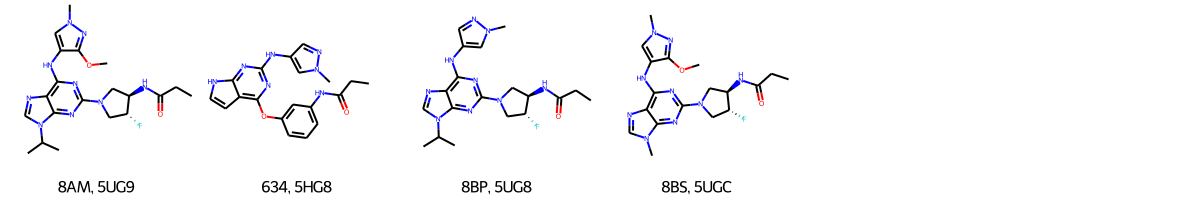

In [25]:
PandasTools.AddMoleculeColumnToFrame(ligands, "smiles")
Draw.MolsToGridImage(
    mols=list(ligands.ROMol),
    legends=list(ligands["@chemicalID"] + ", " + ligands["@structureId"]),
    molsPerRow=top_num,
)

### Create protein-ligand ID pairs

In [26]:
# NBVAL_CHECK_OUTPUT
pairs = collections.OrderedDict(zip(ligands["@structureId"], ligands["@chemicalID"]))
pairs

OrderedDict([('5UG9', '8AM'),
             ('5HG8', '634'),
             ('5UG8', '8BP'),
             ('5UGC', '8BS')])

### Align PDB structures and extract ligands

Since we want to build ligand-based ensemble pharmacophores in the next talktorial, it is necessary to align all structures to each other in 3D. 

We will use the Python package `opencadd` ([repository](https://github.com/volkamerlab/opencadd)), which includes a 3D superposition subpackage  to guide the structural alignment of the proteins. The approach is based on superposition guided by sequence alignment of provided matched residues. There are other methods in the package, but this simple one will be enough for the task at hand.

#### Get the PDB structure files

We now fetch the PDB structure files, i.e. 3D coordinates of the protein, ligand (and if available other atomic or molecular entities such as cofactors, water molecules, and ions) from the PDB using `opencadd.structure.superposition`. 

Available file formats are *pdb* and *cif*, which store the 3D coordinations of atoms of the protein (and ligand, cofactors, water molecules, and ions) as well as information on bonds between atoms. Here, we work with *pdb* files.

In [27]:
# Download PDB structures
structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]
structures

[<Universe with 2664 atoms>,
 <Universe with 2716 atoms>,
 <Universe with 2632 atoms>,
 <Universe with 2542 atoms>]

#### Extract protein and ligand

Extract protein and ligand from the structure in order to remove solvent and other artifacts of crystallography.

In [28]:
complexes = [
    Structure.from_atomgroup(structure.select_atoms(f"protein or resname {ligand}"))
    for structure, ligand in zip(structures, pairs.values())
]
complexes

[<Universe with 2330 atoms>,
 <Universe with 2491 atoms>,
 <Universe with 2319 atoms>,
 <Universe with 2320 atoms>]

In [29]:
# Write complex to file
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(DATA / f"{pdb_id}.pdb")

#### Align proteins

Align complexes (based on protein atoms).

In [30]:
results = align(complexes, method=METHODS["mda"])

`nglview` can be used to visualize molecular data within Jupyter notebooks. With the next cell we will visualize out aligned protein-ligand complexes.

In [31]:
view = nglview.NGLWidget()
for complex_ in complexes:
    view.add_component(complex_.atoms)
view

NGLWidget()

In [32]:
view.render_image(trim=True, factor=2, transparent=True);

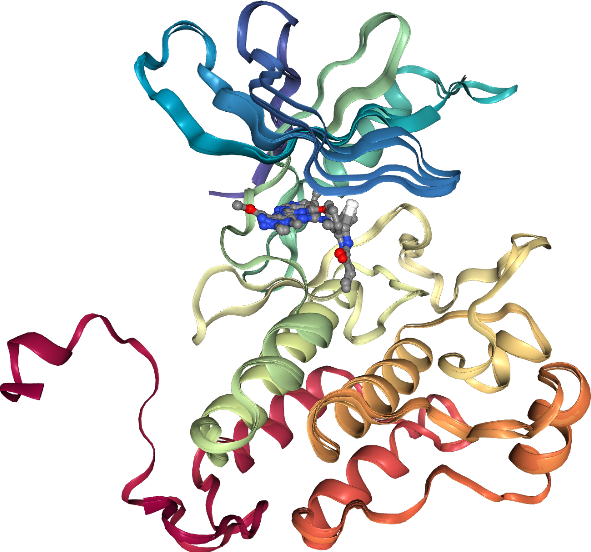

In [33]:
view._display_image()

#### Extract ligands 

In [34]:
ligands = [
    Structure.from_atomgroup(complex_.select_atoms(f"resname {ligand}"))
    for complex_, ligand in zip(complexes, pairs.values())
]
ligands

[<Universe with 32 atoms>,
 <Universe with 28 atoms>,
 <Universe with 30 atoms>,
 <Universe with 30 atoms>]

In [35]:
for ligand, pdb_id in zip(ligands, pairs.keys()):
    ligand.write(DATA / f"{pdb_id}_lig.pdb")

We check the existence of all ligand *pdb* files.

In [36]:
ligand_files = []
for file in DATA.glob("*_lig.pdb"):
    ligand_files.append(file.name)
ligand_files

['5UG9_lig.pdb', '5UGC_lig.pdb', '5HG8_lig.pdb', '5UG8_lig.pdb']

We can also use `nglview` to depict the co-crystallized ligands alone. As we can see, the selected complexes contain ligands populating the same binding pocket and can thus be used in the next talktorial for ligand-based pharmacophore generation.

In [37]:
view = nglview.NGLWidget()
for component_id, ligand in enumerate(ligands):
    view.add_component(ligand.atoms)
    view.remove_ball_and_stick(component=component_id)
    view.add_licorice(component=component_id)
view

NGLWidget()

In [38]:
view.render_image(trim=True, factor=2, transparent=True);

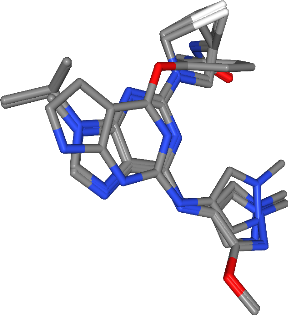

In [39]:
view._display_image()

## Discussion

In this talktorial, we learned how to retrieve protein and ligand meta information and structural information from the PDB. We retained only X-ray structures for EGFR and filtered our data by resolution and ligand availability. Ultimately, we aimed for an aligned set of ligands to be used in the next talktorial for the generation of ligand-based ensemble pharmacophores. 

In order to enrich information about ligands for pharmacophore modeling, it is advisable to not only filter by PDB structure resolution, but also to check for ligand diversity (see **Talktorial T005** on molecule clustering by similarity) and to check for ligand activity (i.e. to include only potent ligands). 

On a technical note: We saw that the different bits of information deposited in the PDB (structural metadata, coordinates, ligand metadata) cannot be accessed at the moment from a single Python package but taking together `biotite` and `pypdb` - and a bit of web scraping to extract ligand information - we were able to collect all the pieces of information that we needed. Given that the PDB only [recently changed completely to a new API (Nov 2020)](https://www4.rcsb.org/news?year=2020&article=5eb18ccfd62245129947212a&feature=true), related open source Python packages might offer more functionalities in the future after having had the time to catch up.

## Quiz

1. Summarize the kind of data that the Protein Data Bank contains.
2. Explain what the resolution of a structure stands for and how and why we filter for it in this talktorial.
3. Explain what an alignment of structures means and discuss the alignment performed in this talktorial.